# Pandas basics 

Hi! In this programming assignment you need to refresh your `pandas` knowledge. You will need to do several [`groupby`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html)s and [`join`]()`s to solve the task. 

In [258]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline 

from grader import Grader
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

In [197]:
DATA_FOLDER = './final_project_data/'

transactions    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))

The dataset we are going to use is taken from the competition, that serves as the final project for this course. You can find complete data description at the [competition web page](https://www.kaggle.com/c/competitive-data-science-final-project/data). To join the competition use [this link](https://www.kaggle.com/t/1ea93815dca248e99221df42ebde3540).

## Grading

We will create a grader instace below and use it to collect your answers. When function `submit_tag` is called, grader will store your answer *locally*. The answers will *not* be submited to the platform immediately so you can call `submit_tag` function as many times as you need. 

When you are ready to push your answers to the platform you should fill your credentials and run `submit` function in the <a href="#Authorization-&-Submission">last paragraph</a>  of the assignment.

In [5]:
grader = Grader()

# Task

Let's start with a simple task. 

<ol start="0">
  <li><b>Print the shape of the loaded dataframes and use [`df.head`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.head.html) function to print several rows. Examine the features you are given.</b></li>
</ol>

In [19]:
print(transactions.shape)
transactions.tail()

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935844,10.10.2015,33,25,7409,299.0,1.0
2935845,09.10.2015,33,25,7460,299.0,1.0
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0


In [20]:
print(items.shape)
items.tail()

(22170, 3)


,item_name,item_id,item_category_id
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62
22169,Яйцо дракона (Игра престолов),22169,69


In [21]:
print(item_categories.shape)
item_categories.tail()

(84, 2)


,item_category_name,item_category_id
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82
83,Элементы питания,83


In [22]:
print(shops.shape)
shops.tail()

(60, 2)


,shop_name,shop_id
55,Цифровой склад 1С-Онлайн,55
56,"Чехов ТРЦ ""Карнавал""",56
57,"Якутск Орджоникидзе, 56",57
58,"Якутск ТЦ ""Центральный""",58
59,"Ярославль ТЦ ""Альтаир""",59


---

Now use your `pandas` skills to get answers for the following questions. 
The first question is:

1. ** What was the maximum total revenue among all the shops in September, 2014?** 


* Hereinafter *revenue* refers to total sales minus value of goods returned.

*Hints:*

* Sometimes items are returned, find such examples in the dataset. 
* It is handy to split `date` field into [`day`, `month`, `year`] components and use `df.year == 14` and `df.month == 9` in order to select target subset of dates.
* You may work with `date` feature as with srings, or you may first convert it to `pd.datetime` type with `pd.to_datetime` function, but do not forget to set correct `format` argument.

In [221]:
transactions['date'] = pd.to_datetime(transactions['date'], format='%d.%m.%Y')
df1 = transactions[(transactions['date'].dt.year == 2014)&(transactions['date'].dt.month == 9)]
df1['total'] = df1['item_price']*df1['item_cnt_day']
df2 = pd.DataFrame(df1.groupby(['shop_id','item_id'])['total'].sum())

max_revenue = df2.groupby('shop_id')['total'].sum().max()
grader.submit_tag('max_revenue', max_revenue)

Current answer for task max_revenue is: 7982852.199999959


---

Great! Let's move on and answer another question:

<ol start="2">
  <li><b>What item category generated the highest revenue in summer 2014?</b></li>
</ol>

* Submit `id` of the category found.
    
* Here we call "summer" the period from June to August.

*Hints:*

* Note, that for an object `x` of type `pd.Series`: `x.argmax()` returns **index** of the maximum element. `pd.Series` can have non-trivial index (not `[1, 2, 3, ... ]`).

In [106]:
df1 = pd.merge(transactions, items, on='item_id')
df2 = df[(df['date'].dt.year == 2014) 
             & ((df['date'].dt.month == 6) 
              | (df['date'].dt.month == 7) 
              | (df['date'].dt.month == 8))]


category_id_with_max_revenue = (df2.groupby('item_category_id')['item_price'].first() 
                                * df2.groupby('item_category_id')['item_cnt_day'].sum()).argmax()
grader.submit_tag('category_id_with_max_revenue', category_id_with_max_revenue)

Current answer for task category_id_with_max_revenue is: 20


---

<ol start="3">
  <li><b>How many items are there, such that their price stays constant (to the best of our knowledge) during the whole period of time?</b></li>
</ol>

* Let's assume, that the items are returned for the same price as they had been sold.

In [259]:
l=[]
for item_id in tqdm(transactions['item_id'].unique()):
    if len(set(transactions.loc[transactions['item_id']==item_id, 'item_price']))==1:
        l.append(item_id)

num_items_constant_price = len(l)
grader.submit_tag('num_items_constant_price', num_items_constant_price)

100%|██████████| 21807/21807 [01:01<00:00, 354.92it/s]

Current answer for task num_items_constant_price is: 5926


Remember, the data can sometimes be noisy.

---

<ol start="4">
  <li><b>What was the variance of the number of sold items per day sequence for the shop with `shop_id = 25` in December, 2014? ~~Do not count the items, that were sold but returned back later.~~</b></li>
</ol>

* Fill `total_num_items_sold` and `days` arrays, and plot the sequence with the code below.
* Then compute variance. Remember, there can be differences in how you normalize variance (biased or unbiased estimate, see [link](https://math.stackexchange.com/questions/496627/the-difference-between-unbiased-biased-estimator-variance)). Compute ***unbiased*** estimate (use the right value for `ddof` argument in `pd.var` or `np.var`). 

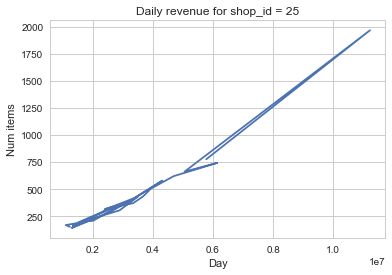

Current answer for task total_num_items_sold_var is: 117167.70229885059


In [409]:
shop_id = 25

df1 = transactions[(transactions['date'].dt.year == 2014)&(transactions['date'].dt.month == 12)]
df2 = df1[df1['shop_id']==shop_id]

# df = pd.DataFrame(df2.groupby('item_id')['item_cnt_day'].min())
# del_item_list = list(df[df['item_cnt_day']<0].index)
# for item_id in del_item_list:
#     df2.drop(df2[df2['item_id']==item_id].index, inplace=True)    
    
total_num_items_sold = df2.groupby('date')['item_cnt_day'].sum()
days = df2.groupby('date')['item_id'].sum()

# Plot it
plt.plot(days, total_num_items_sold)
plt.ylabel('Num items')
plt.xlabel('Day')
plt.title("Daily revenue for shop_id = 25")
plt.show()

total_num_items_sold_var = np.var(total_num_items_sold, ddof=1)
grader.submit_tag('total_num_items_sold_var', total_num_items_sold_var)

---

## Authorization & Submission
To submit assignment to Cousera platform, please, enter your e-mail and token into the variables below. You can generate token on the programming assignment page. *Note:* Token expires 30 minutes after generation.

In [411]:
STUDENT_EMAIL = 'dnjscjf92@ajou.ac.kr'
STUDENT_TOKEN = 'nVn4Pb3VuB9VyWvq'
grader.status()

You want to submit these numbers:
Task max_revenue: 7982852.199999959
Task category_id_with_max_revenue: 20
Task num_items_constant_price: 5926
Task total_num_items_sold_var: 117167.70229885059


In [412]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Submitted to Coursera platform. See results on assignment page!


Well done! :)